### Домашнее задание к занятию «Сингулярный спектральный анализ»

Провести анализ с помощью SSA на любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)


def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.legend()
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [3]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

Возьму временной ряд с данными о количестве международных авиаперелетов. У этого ряда есть выраженный тренд и сезонные колебания, предположительно, он должен неплохо описываться компонентами SSA

In [4]:
ts = pd.read_csv('Series/international-airline-passengers.csv')['Count']

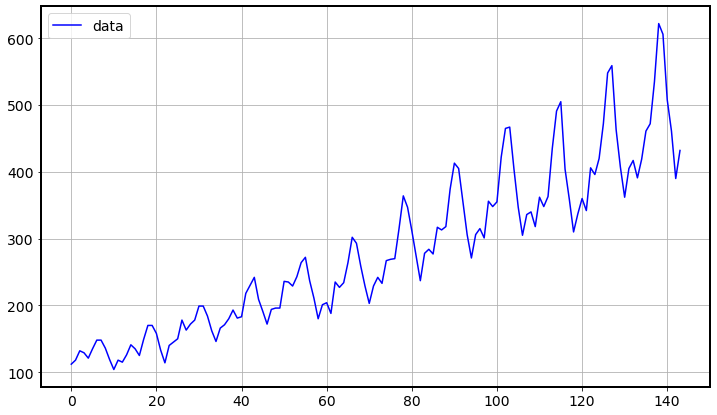

In [10]:
plt.figure(figsize=(12,7))
plt.plot(ts, color='blue', label='data')
plt.grid()
plt.legend()

In [11]:
len(ts)

144

Длина окна L не должна превышать половину длины временного ряда (в этом случае 72). Попробуем окна различной длины

#### L=5

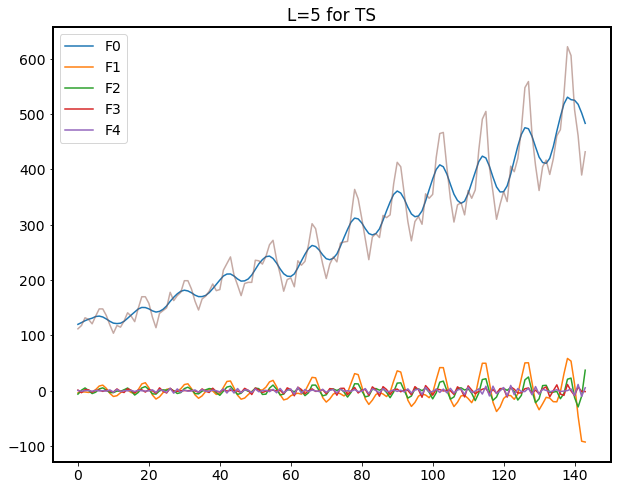

In [21]:
L = 5
ssa_5 = SSA(ts, window)
ssa_5.components_to_df().plot()
ssa_5.orig_TS.plot(alpha=0.5)
plt.title('L={} for TS'.format(window))

Получилось, что $F0$ - компонент, отвечающий за тренд  
$F1, F2$ похоже отвечают за сезоность,  
оставшиеся $F3, F4$ представляют шум


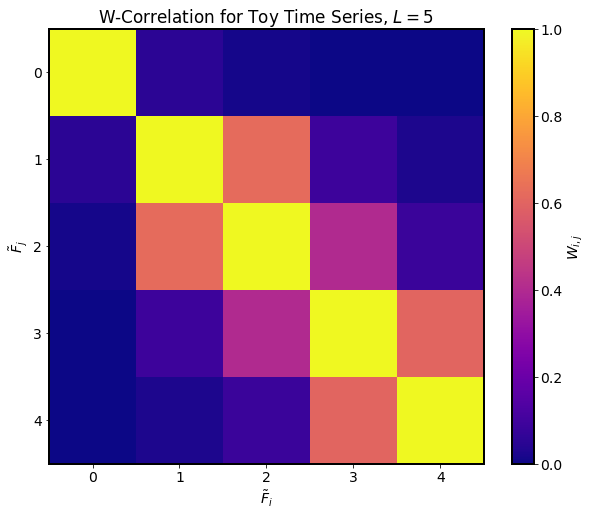

In [22]:
ssa_5.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=5$");

Матрица корреляций подтверждает, что F0 тренд, однако между остальными компонентами есть связь, возможно, стоит их сгруппировать

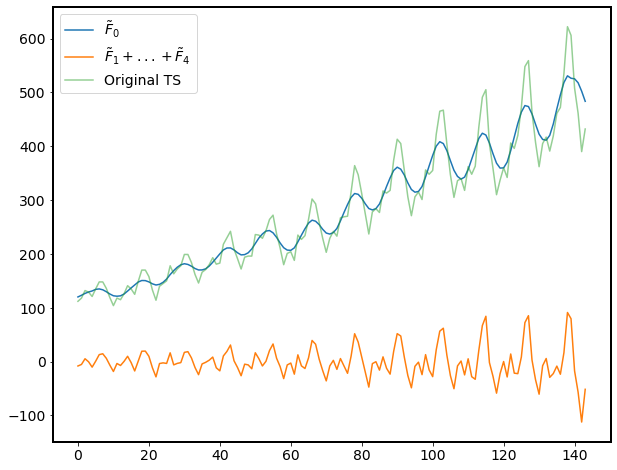

In [25]:
ssa_5.reconstruct(0).plot()
ssa_5.reconstruct(slice(1, 5)).plot()
ssa_5.orig_TS.plot(alpha=0.5)
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+...+\tilde{F}_4$", 
            'Original TS'])

Получили отдельно основной тренд (нелинейный), отдельно сезонные колебания, очень похожие на исходную форму ряда (но уже без тренда)

#### L=25

In [27]:
L = 25
ssa_25 = SSA(ts, L)

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=25$')

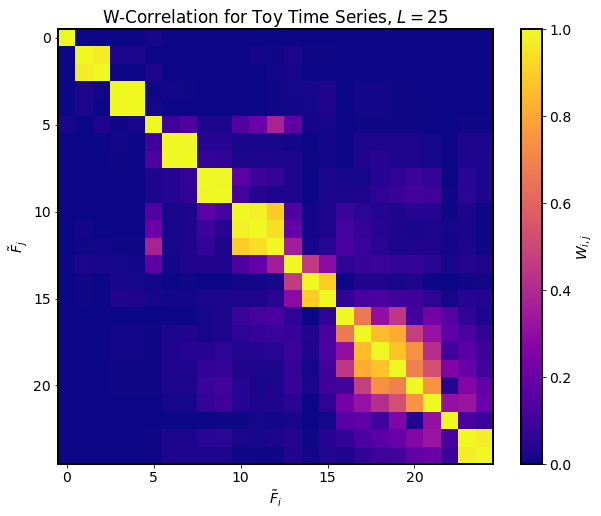

In [28]:
ssa_25.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=25$")

Судя по графику корреляции, имеет смысл разбить компоненты по следующим группам:  
$F0$ отдельно,  
$F1$ и $F2$,   
$F3$ и $F4$,   
с $F5$ по $F25$   

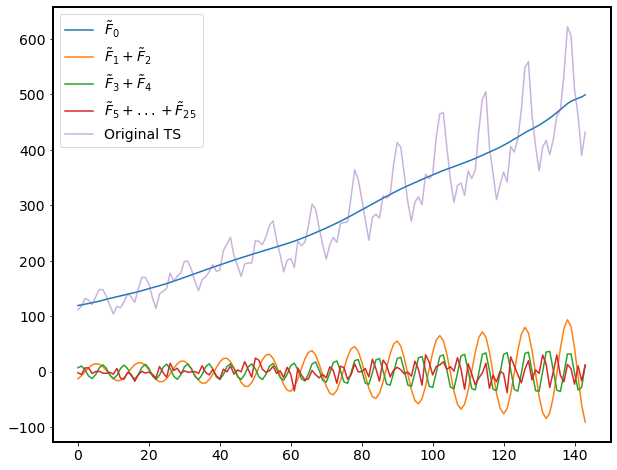

In [61]:
ssa_25.reconstruct(0).plot()
ssa_25.reconstruct([1, 2]).plot()
ssa_25.reconstruct([3, 4]).plot()
ssa_25.reconstruct(slice(5, 25)).plot()
ssa_25.orig_TS.plot(alpha=0.5)
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+...+\tilde{F}_{25}$", 
            'Original TS'])

На этот раз тренд почти прямой, группы из (F1, F2) и (F3, F4) представляют цикличные колебания разной амплитуды, остальные компоненты сложились в некий шум. Причем если мы более детально посмотрим (графики ниже) на цикличные компоненты, то можем выявить у них вполне четкую сезоность, 12 месяцев для группы (F1, F2) и 6 месяцев для (F3, F4)     

In [49]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')
        plt.title('Season length = {}'.format(step))

In [50]:
seasonals_1 = ssa_25.reconstruct([1, 2])

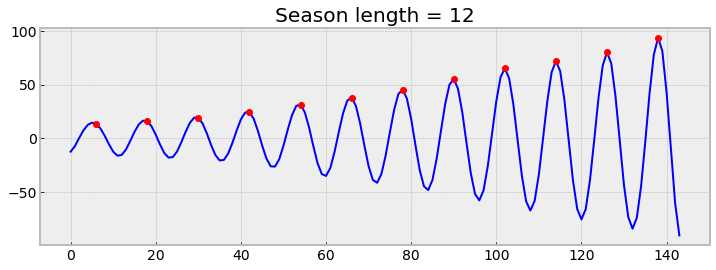

In [51]:
plot_ts_and_points(seasonals_1, 6, 12)

In [52]:
seasonals_2 = ssa_25.reconstruct([3, 4])

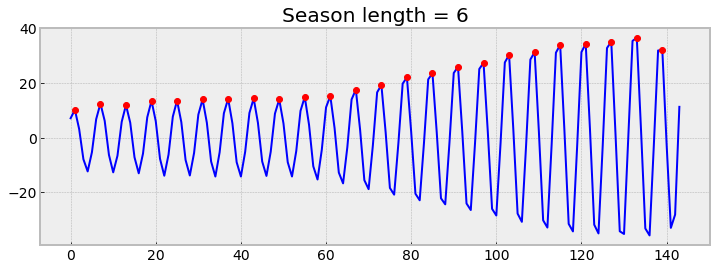

In [53]:
plot_ts_and_points(seasonals_2, 1, 6)

Создается впечатление, что это количество компонент уже неплохо описывает исходный ряд. Однако попробуем еще увеличить длину окна

#### L=50

In [54]:
L = 50
ssa_50 = SSA(ts, L)

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=50$')

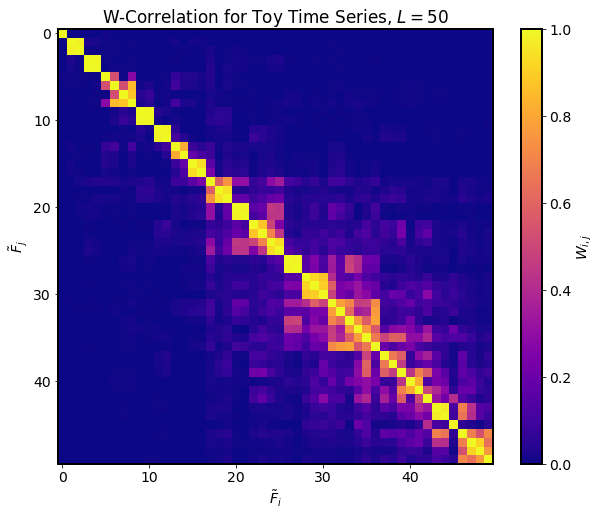

In [55]:
ssa_50.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=50$")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=50$ (Zoomed)')

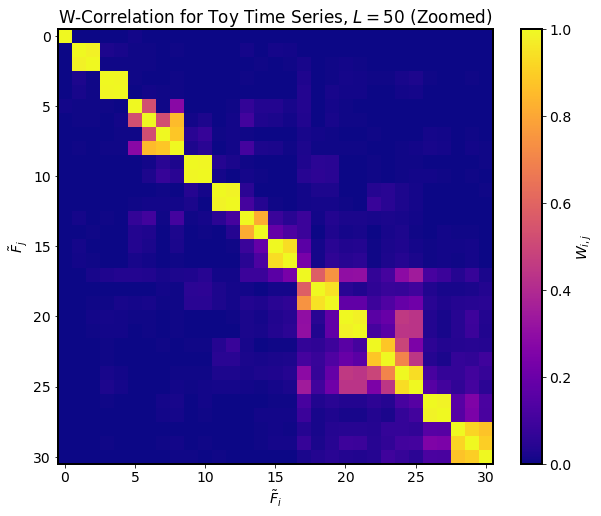

In [56]:
ssa_50.plot_wcorr(max=30)
plt.title("W-Correlation for Toy Time Series, $L=50$ (Zoomed)")

Так же, как и в предыдущем случае, мы получаем группы $F0$ отдельно, $F1$ и $F2$, $F3$ и $F4$, а дальше можно попробовать объединить с $F5$ по $F8$, $F9$ и $F10$, $F11$ и $F12$, и все остальное с 13 по 50й компоненты

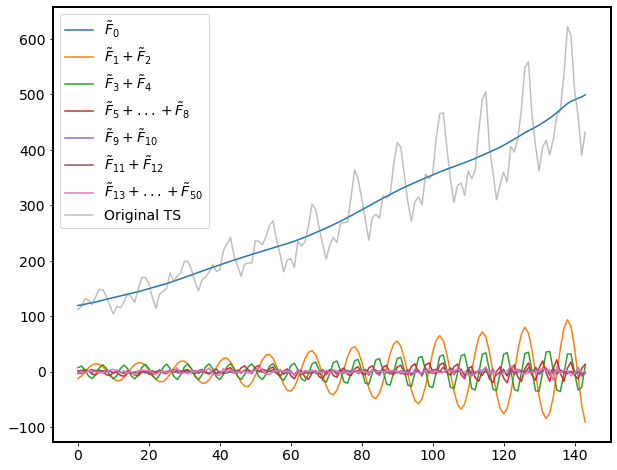

In [60]:
ssa_25.reconstruct(0).plot()
ssa_25.reconstruct([1, 2]).plot()
ssa_25.reconstruct([3, 4]).plot()
ssa_25.reconstruct(slice(5, 8)).plot()
ssa_25.reconstruct([9, 10]).plot()
ssa_25.reconstruct([11, 12]).plot()
ssa_25.reconstruct(slice(13, 50)).plot()
ssa_25.orig_TS.plot(alpha=0.5)
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+...+\tilde{F}_8$", 
            r"$\tilde{F}_9+\tilde{F}_{10}$",
            r"$\tilde{F}_{11}+\tilde{F}_{12}$", 
            r"$\tilde{F}_{13}+...+\tilde{F}_{50}$", 
            'Original TS'])

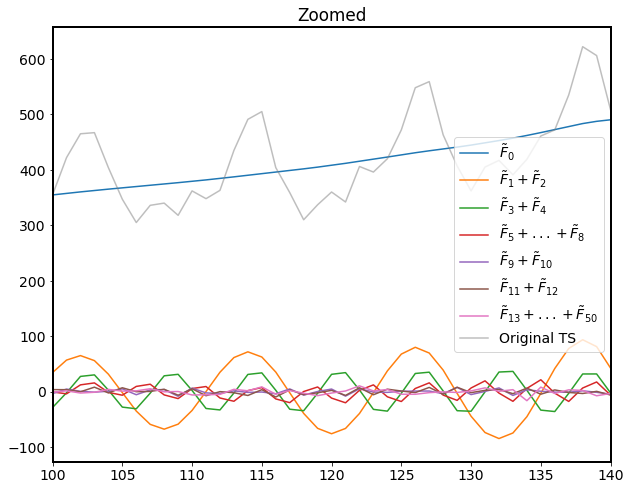

In [63]:
ssa_25.reconstruct(0).plot()
ssa_25.reconstruct([1, 2]).plot()
ssa_25.reconstruct([3, 4]).plot()
ssa_25.reconstruct(slice(5, 8)).plot()
ssa_25.reconstruct([9, 10]).plot()
ssa_25.reconstruct([11, 12]).plot()
ssa_25.reconstruct(slice(13, 50)).plot()
ssa_25.orig_TS.plot(alpha=0.5)
plt.xlim(100, 140)
plt.title('Zoomed')
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+...+\tilde{F}_8$", 
            r"$\tilde{F}_9+\tilde{F}_{10}$",
            r"$\tilde{F}_{11}+\tilde{F}_{12}$", 
            r"$\tilde{F}_{13}+...+\tilde{F}_{50}$", 
            'Original TS'])

Увеличение длины окна дало нам еще одну выделяющуюся цикличную компоненту сезонностью примерно 4 месяца. Остальные группы компонент уже сливаются в одну картинку и плохо различимы между собой 

In [64]:
seasonals_3 = ssa_25.reconstruct(slice(5, 8))

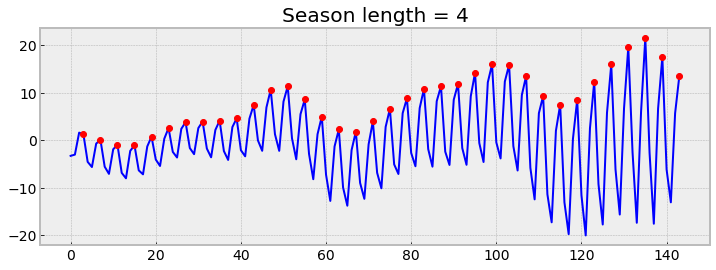

In [68]:
plot_ts_and_points(seasonals_3, 3, 4)

Если мы оставим тренд, 3 группы цкличных компонент и шум, получим следующую картинку.

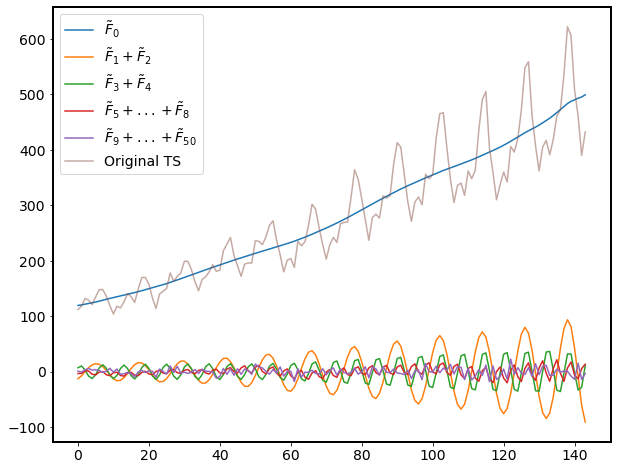

In [69]:
ssa_25.reconstruct(0).plot()
ssa_25.reconstruct([1, 2]).plot()
ssa_25.reconstruct([3, 4]).plot()
ssa_25.reconstruct(slice(5, 8)).plot()
ssa_25.reconstruct(slice(9, 50)).plot()
ssa_25.orig_TS.plot(alpha=0.5)

plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+...+\tilde{F}_8$", 
            r"$\tilde{F}_9+...+\tilde{F}_{50}$", 
            'Original TS'])

Считаю, что этих компонент достаточно для описания нашего ряда